In [242]:
import wandb
from math import isnan 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
from tqdm import tqdm
from cycler import cycler
import matplotlib as mpl

wandb_id = "" # YOUR WANDB ID
api = wandb.Api()
project = "FedResFinal"
runs = api.runs(f"{wandb_id}/{project}")
all_runs = []
for run in runs:
    if run.State=="finished" and "n_workers" in run.config and run.config["heterogeneity"]=="dir" and run.config["imbalance"] and "lambda/client_0" in run.summary:# and run.config["heterogeneity"]=="mix":
        for client in tqdm(range(config["n_workers"])):
            split="test"
            slack_test = run.summary[f"loss/{split}/client_{client}"]-run.summary[f"loss/{split}/mean"]
            split="train"
            slack_train = run.summary[f"loss/{split}/client_{client}"]-run.summary[f"loss/{split}/mean"]
            run_dict = {**run.config, **run.summary, "client":client,
                        "constraint_gap":slack_test-slack_train,
                        "dual":run.summary[f"lambda/client_{client}"],
                            "run": run.id}
            #run_dict["slack_diff"] = 
            all_runs.append(run_dict)
df = pd.DataFrame(all_runs)               

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1651.55it/s]
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1658.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1665.17it/s]


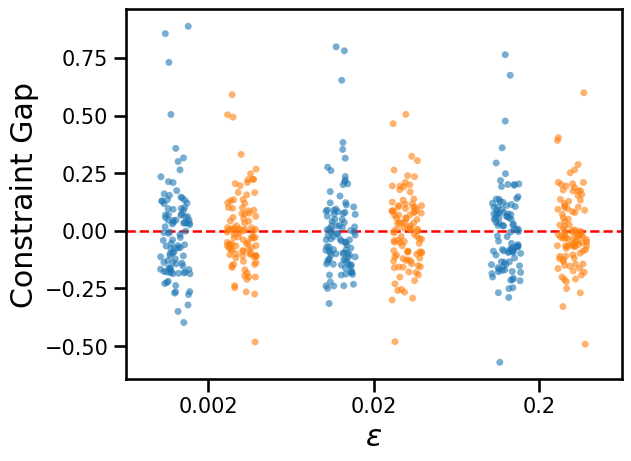

In [243]:
import seaborn as sns
import matplotlib as mpl
sns.set_context("talk", font_scale=1.2)
mpl.rcParams['lines.linewidth'] = 1.8

df = df[df["dataset"]=="cifar10"]
query_df = df.query("imbalance==True and n_minority==3 and reduce_to_ratio==0.1 and perturbation_penalty==2.0 and tolerance_epsilon>=0.002")
query_df = query_df.replace({"imbalance-fl": "Constrained", "imbalance-fl-res": "Resilient"})
query_df["Formulation"] =query_df["formulation"]
query_df = query_df.sort_values(["Formulation", "tolerance_epsilon"], ascending=[True, True])
ax = sns.stripplot(data=query_df, y="constraint_gap", x="tolerance_epsilon", hue="Formulation", alpha=0.6, dodge=True, jitter=0.18)
plt.axhline(y=0, color="r", linestyle = 'dashed')
plt.legend(fontsize=16,title_fontsize=16, loc='upper right', title="Formulation", bbox_to_anchor=(1.6, 1.0))
ax.get_legend().remove()
ax.tick_params(axis="x",  labelsize=15)
ax.tick_params(axis="y",  labelsize=15)
plt.xlabel("$\epsilon$")
plt.ylabel("Constraint Gap")
plt.savefig("Slack_gap_vs_epsilon.pdf",  bbox_inches="tight", dpi=250)

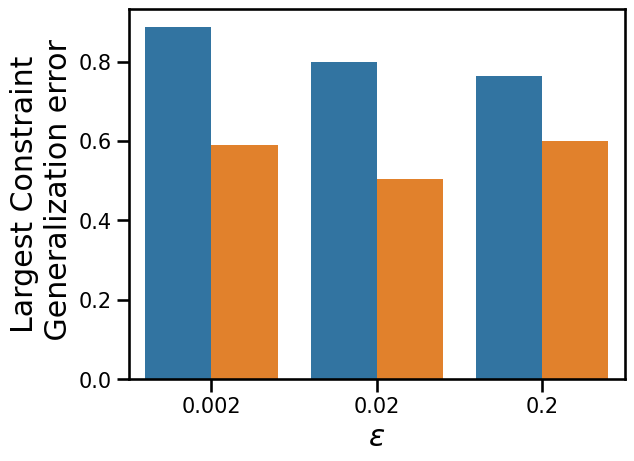

In [244]:
import seaborn as sns
import matplotlib as mpl
n_largest=1
sns.set_context("talk", font_scale=1.2)
mpl.rcParams['lines.linewidth'] = 1.8

df = df[df["dataset"]=="cifar10"]
query_df = df.query("imbalance==True and n_minority==3 and reduce_to_ratio==0.1 and perturbation_penalty==2.0 and tolerance_epsilon>=0.002")
query_df = query_df.replace({"imbalance-fl": "Constrained", "imbalance-fl-res": "Resilient"})
query_df["Formulation"] =query_df["formulation"]
query_df = query_df.sort_values(["Formulation", "tolerance_epsilon"], ascending=[True, True])
for run, run_df in query_df.groupby("run"):
    largest = run_df.nlargest(n_largest, 'constraint_gap')["client"].values
    query_df = query_df.loc[~((query_df['run'] == run) & ~(query_df['client'].isin(largest) ))]
gaps = []
for run, run_df in query_df.groupby("run"):
    run_dict = {"max": run_df["constraint_gap"].max(), "mean":run_df["constraint_gap"].mean(),
               'tolerance_epsilon':run_df["tolerance_epsilon"].values[0], 'Formulation':run_df["Formulation"].values[0]}    
ax = sns.barplot(data=query_df, y="constraint_gap", x="tolerance_epsilon", hue="Formulation")
plt.legend(fontsize=16,title_fontsize=16, loc='upper right', title="Formulation", bbox_to_anchor=(1.6, 1.0))
ax.get_legend().remove()
ax.tick_params(axis="x",  labelsize=15)
ax.tick_params(axis="y",  labelsize=15)
plt.xlabel("$\epsilon$")
plt.ylabel("Largest Constraint\n Generalization error")
plt.savefig("Slack_gap_vs_epsilon.pdf",  bbox_inches="tight", dpi=250)